In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/RL/DRQN


Mounted at /content/drive
/content/drive/MyDrive/RL/DRQN


In [2]:
!pip install -r requirements.txt

# DRQN

In [2]:
%cd DRQN

/content/drive/MyDrive/RL/DRQN/DRQN


/content/drive/My Drive/RL/DRQN/DRQN/model.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


0 episode | score: 12.00 | epsilon: 1.00
10 episode | score: 17.00 | epsilon: 1.00
20 episode | score: 19.00 | epsilon: 1.00
30 episode | score: 11.00 | epsilon: 1.00
40 episode | score: 17.00 | epsilon: 1.00
50 episode | score: 11.00 | epsilon: 0.99
60 episode | score: 40.00 | epsilon: 0.98
70 episode | score: 10.00 | epsilon: 0.97
80 episode | score: 12.00 | epsilon: 0.96
90 episode | score: 15.00 | epsilon: 0.95
100 episode | score: 24.00 | epsilon: 0.94
110 episode | score: 18.00 | epsilon: 0.93
120 episode | score: 22.00 | epsilon: 0.92
130 episode | score: 23.00 | epsilon: 0.91
140 episode | score: 14.00 | epsilon: 0.89
150 episode | score: 15.00 | epsilon: 0.89
160 episode | score: 11.00 | epsilon: 0.88
170 episode | score: 10.00 | epsilon: 0.87
180 episode | score: 20.00 | epsilon: 0.86
190 episode | score: 35.00 | epsilon: 0.85
200 episode | score: 16.00 | epsilon: 0.84
210 episode | score: 31.00 | epsilon: 0.83
220 episode | score: 31.00 | epsilon: 0.81
230 episode | score: 3

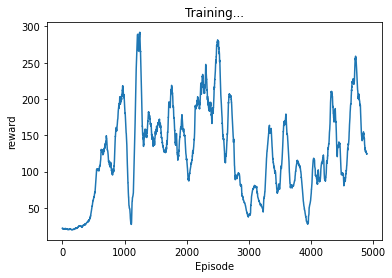

In [3]:
import os
import sys
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn.functional as F
from model import DRQN
from memory import Memory
from env import partial_env_class
from config import env_name, initial_exploration, batch_size, update_target, goal_score, log_interval, device, replay_memory_capacity, lr, max_epsilon

from collections import deque

def get_action(state, online_net, epsilon, partial_env, hidden):
    # This function gives an action for a corresponding state based on the epsilon-greedy exploration strategy. 
    # state represents the state variable. 
    # Epsilon is the exploration variable. 
    # Partial_env represents the environment variable 
    # hidden represents the hidden and cell state information for LSTM 
    # Online net is the Q network from which the actions need be obtained. 

    action, hidden = online_net.get_action(state, hidden)
    
    if np.random.rand() <= epsilon:
        return partial_env.get_random_action(), hidden
    else:
        return action, hidden

def update_target_model(online_net, target_net):
    # Target <- Net
    target_net.load_state_dict(online_net.state_dict())


def main():
    # Perform training and plot results
    # Since this is a partially observable environment, the state variable actually represents the observation. 

    partial_env = partial_env_class()
    partial_env.set_seed(500)
    torch.manual_seed(500)

    num_inputs = partial_env.num_states()
    num_actions = partial_env.num_actions()

    online_net = DRQN(num_inputs, num_actions)
    target_net = DRQN(num_inputs, num_actions)
    update_target_model(online_net, target_net)

    optimizer = optim.Adam(online_net.parameters(), lr=lr)

    online_net.to(device)
    target_net.to(device)
    online_net.train()
    target_net.train()
    memory = Memory(replay_memory_capacity)
    running_score = 0
    epsilon = 1.0
    steps = 0
    score_list = []

    for e in range(5000):
        done = False

        score = 0
        state = partial_env.reset()
        state = torch.Tensor(state).to(device)

        hidden = (torch.Tensor().new_zeros(1, 1, 16).to(device), torch.Tensor().new_zeros(1, 1, 16).to(device))
        
        running_steps = 0
        while not done and running_steps < 500:
            steps += 1

            action, new_hidden = get_action(state, online_net, epsilon, partial_env, hidden)
            next_state, reward, done = partial_env.step(action)
            next_state = torch.Tensor(next_state).to(device)

            mask = 0 if done else 1

            memory.push(state, next_state, action, reward, mask, hidden)
            hidden = new_hidden

            score += reward
            state = next_state

            running_steps = running_steps + 1
            if steps > initial_exploration and len(memory) > batch_size:
                epsilon -= 0.00005
                epsilon = max(epsilon, max_epsilon)

                batch = memory.sample(batch_size)
                DRQN.train_model(online_net, target_net, optimizer, batch)

                if steps % update_target == 0:
                    update_target_model(online_net, target_net)

        score_list.append(score)

        if e % log_interval == 0:
            print('{} episode | score: {:.2f} | epsilon: {:.2f}'.format(
                e, score, epsilon))

    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('reward')
    moving_averages= []
    i = 0
    while i < len(score_list) - 100 + 1:
        this_window = score_list[i : i + 100]
        window_average = sum(this_window) / 100
        moving_averages.append(window_average)
        i += 1
    Ep_arr = np.array(moving_averages)
    plt.plot(Ep_arr)
    plt.savefig('./drqncartpole.png')

if __name__=="__main__":
    main()


# DQN

In [ ]:
%cd ../DQN

In [ ]:
!ls

In [ ]:
import os
import sys
import random
import numpy as np

import torch
import torch.optim as optim
import torch.nn.functional as F
from model import QNet
from memory import Memory
from env import partial_env_class
from config import initial_exploration, batch_size, update_target, goal_score, log_interval, device, replay_memory_capacity, lr, sequence_length, max_epsilon
from collections import deque
import matplotlib
import matplotlib.pyplot as plt


def get_action(state_series, online_net, epsilon, partial_env):
    # This function gives an action for a corresponding state based on the epsilon-greedy exploration strategy. 
    # state_series represents the state variable which contains the last 4 observations. 
    # Epsilon is the exploration variable. 
    # Partial_env represents the environment variable.
    # Online net is the Q network from which the actions need be obtained. 


    if np.random.rand() <= epsilon or len(state_series) < sequence_length:
        return partial_env.get_random_action()
    else:
        return online_net.get_action(torch.stack(list(state_series)))

def update_target_model(online_net, target_net):
    # Target <- Net
    target_net.load_state_dict(online_net.state_dict())


def main():
    # Perform training and plot results. 
    # Since this is a partially observable environment, the state variable actually represents the observation. 

    partial_env = partial_env_class()
    partial_env.set_seed(500)
    torch.manual_seed(500)

    num_inputs = partial_env.num_states()
    num_actions = partial_env.num_actions()
    print('state size:', num_inputs)
    print('action size:', num_actions)

    online_net = QNet(num_inputs, num_actions)
    target_net = QNet(num_inputs, num_actions)
    update_target_model(online_net, target_net)

    optimizer = optim.Adam(online_net.parameters(), lr=lr)

    online_net.to(device)
    target_net.to(device)
    online_net.train()
    target_net.train()
    memory = Memory(replay_memory_capacity)
    running_score = 0
    epsilon = 1.0
    steps = 0
    score_list = []
    for e in range(10000):
        done = False

        state_series = deque(maxlen=sequence_length)
        next_state_series = deque(maxlen=sequence_length)
        score = 0
        state = partial_env.reset() 
        state = torch.Tensor(state).to(device)
        running_step = 0
        while not done and running_step<500:
            steps += 1
            state_series.append(state)
            action = get_action(state_series, online_net, epsilon, partial_env)
            next_state, reward, done = partial_env.step(action)

            next_state = torch.Tensor(next_state).to(device)

            next_state_series.append(next_state)
            mask = 0 if done else 1
            
            action_one_hot = np.zeros(2)
            action_one_hot[action] = 1
            if len(state_series) >= sequence_length:
                memory.push(state_series, next_state_series, action_one_hot, reward, mask)

            score += reward
            state = next_state
            running_step += 1

            if steps > initial_exploration:
                epsilon -= 0.000005
                epsilon = max(epsilon, max_epsilon)

                batch = memory.sample(batch_size)
                QNet.train_model(online_net, target_net, optimizer, batch)

                if steps % update_target == 0:
                    update_target_model(online_net, target_net)

        score_list.append(score)
        if e % log_interval == 0:
            print('{} episode | score: {:.2f} | epsilon: {:.2f}'.format(
                e, score, epsilon))


    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('reward')
    moving_averages= []
    i = 0
    while i < len(score_list) - 100 + 1:
        this_window = score_list[i : i + 100]
        window_average = sum(this_window) / 100
        moving_averages.append(window_average)
        i += 1
    Ep_arr = np.array(moving_averages)
    plt.plot(Ep_arr)
    plt.savefig('./dqncartpole.png')



if __name__=="__main__":
    main()


# Comparision

In [12]:
!ls 

config.py  drqncartpole.png  env.py  memory.py	model.py  __pycache__  train.py


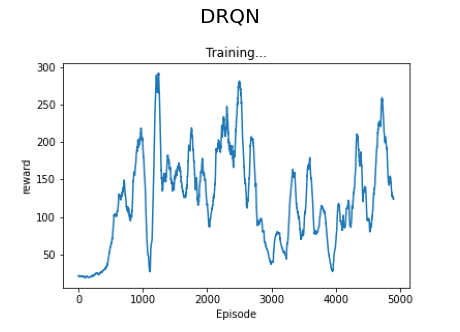

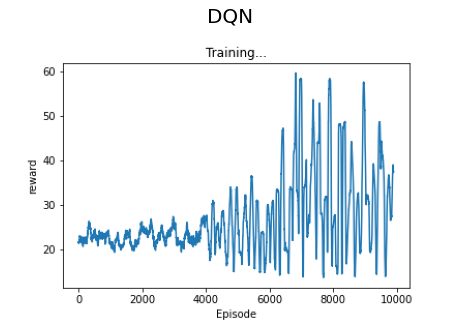

In [14]:
DRQN = plt.imread("drqncartpole.png")
DQN = plt.imread("../DQN/dqncartpole.png")

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(DRQN)
ax.axis('off')
ax.set_title("DRQN", fontsize=20)

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(DQN)
ax.axis('off')
ax.set_title("DQN", fontsize=20)

plt.show()

Obviously, DRQN outperforms DQN, i.e. it achieves high rewrards that DQN cannot, and also it reaches to those considerable rewards quite fast. 

Taking advantage of LSTM can explain this achievement since it produces some state alongside the output and it uses that state in the following epochs. In this way, it can exploit a longer history of observations to approximate the original state compared to DQN which only uses the last 4 observations here. This fact of approximating the original state more effectively helps choose more appropriate actions in each observed state. Indeed, the result of the experiment indicates that DQN is not able to easily capture the underly state space of this problem even if we use a limited sequence of last observations.